### 2448547 Shishir Salian LAB 1 Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

The source-filter model is a fundamental concept in speech processing that describes speech production as a two-step process:

1.  **Source:** A source signal is generated by the lungs and vocal folds (glottis). This is either a periodic pulse train for voiced sounds or random noise for unvoiced sounds.
2.  **Filter:** The source signal then passes through the vocal tract (the throat, mouth, and nasal cavities), which acts as a time-varying filter. This filter shapes the spectrum of the source signal, creating the different sounds of speech by emphasizing certain frequencies (called formants).

In this task, we will create a synthetic speech signal by first generating a source and then applying a filter to it.

## 1. Create the Source Signal

First, we'll generate the two types of source signals as described in the model.

*   **Voiced Source (Pulse Train):** We create a series of pulses at a specific fundamental frequency (F0). A typical male F0 is around 120 Hz, and a female F0 is around 210 Hz.
*   **Unvoiced Source (White Noise):** We generate random values to simulate the turbulent airflow for sounds like 'sh' or 'f'.

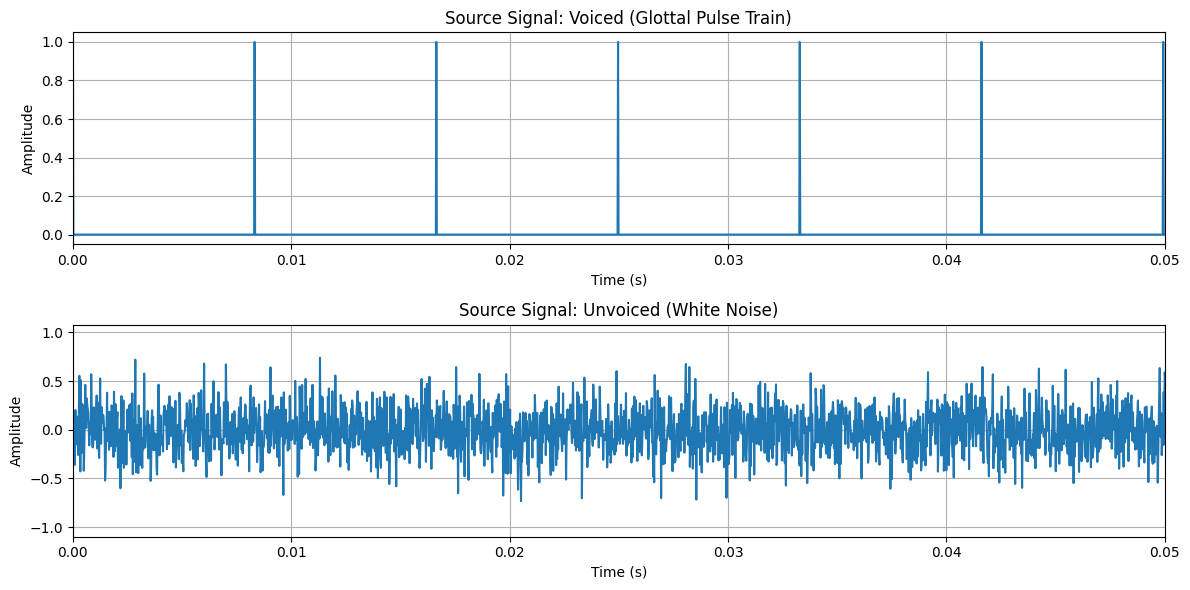

In [2]:
# (a.i) Create a source signal

# --- Parameters ---
sample_rate = 44100  # Hz
duration = 15        # seconds
F0 = 120             # Fundamental frequency for voiced sound (in Hz)

# --- Generate Time Vector ---
t = np.linspace(0., duration, int(sample_rate * duration), endpoint=False)

# --- 1. Voiced Source (Glottal Pulse Train) ---
# Create a pulse train: a pulse at every 1/F0 seconds
pulse_train = np.zeros_like(t)
pulse_period_samples = int(sample_rate / F0)
for i in range(0, len(pulse_train), pulse_period_samples):
    pulse_train[i] = 1

# --- 2. Unvoiced Source (White Noise) ---
white_noise = np.random.randn(len(t))
# Normalize to be between -1 and 1
white_noise /= np.max(np.abs(white_noise))


# --- Plot the Source Signals ---
plt.figure(figsize=(12, 6))

# Plot Pulse Train
plt.subplot(2, 1, 1)
plt.plot(t, pulse_train)
plt.title('Source Signal: Voiced (Glottal Pulse Train)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05) # Zoom in to see a few pulses
plt.grid(True)

# Plot White Noise
plt.subplot(2, 1, 2)
plt.plot(t, white_noise)
plt.title('Source Signal: Unvoiced (White Noise)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05) # Zoom in to see the noise structure
plt.grid(True)

plt.tight_layout()
plt.show()

## 2. Create the Vocal Tract Filter and Generate Speech

Now we create the filter. We will model the vocal tract as an **all-pole filter**, which is a good approximation for non-nasal vowels. The filter is defined by the locations of its poles, which correspond to the **formants** of a speech sound.

We will define the first three formants (F1, F2, F3) and their bandwidths to simulate a vowel sound. For this example, we'll use formants that approximate the vowel /a/ (as in "cat").

Once the filter is created, we apply it to our source signals (pulse train and white noise) to generate synthetic speech.

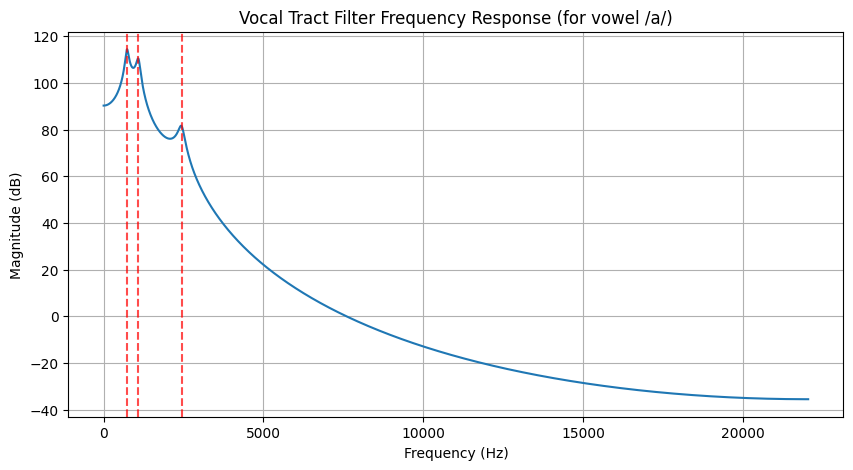

In [3]:
# (a.ii) Apply a filter that models the vocal tract

def formants_to_filter(formants, bandwidths, fs):
    """Converts formant frequencies and bandwidths to all-pole filter coefficients."""
    # This is a simplified way to create filter coefficients from formants.
    # It creates second-order sections for each formant and combines them.
    a_coeffs = np.array([1.0])
    for F, BW in zip(formants, bandwidths):
        # Convert formant frequency and bandwidth to pole radius and angle
        r = np.exp(-np.pi * BW / fs)
        theta = 2 * np.pi * F / fs
        # Create second-order section for this formant
        a_k = np.array([1, -2 * r * np.cos(theta), r**2])
        # Convolve with the existing filter coefficients
        a_coeffs = np.convolve(a_coeffs, a_k)
    return a_coeffs

# --- Filter Parameters (for vowel /a/) ---
formant_freqs = [730, 1090, 2440]  # Hz
formant_bws = [90, 110, 170]      # Hz

# --- Create Filter Coefficients ---
# The 'b' coefficient is just [1] for an all-pole filter
b_coeffs = np.array([1.0])
a_coeffs = formants_to_filter(formant_freqs, formant_bws, sample_rate)

# --- Plot the Filter's Frequency Response ---
w, h = signal.freqz(b_coeffs, a_coeffs, worN=8000, fs=sample_rate)
plt.figure(figsize=(10, 5))
plt.plot(w, 20 * np.log10(abs(h)))
for f in formant_freqs:
    plt.axvline(f, color='r', linestyle='--', alpha=0.7)
plt.title("Vocal Tract Filter Frequency Response (for vowel /a/)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

## 3. Plot the Generated Speech Signal

Now we apply the filter to the source signals and observe the result.

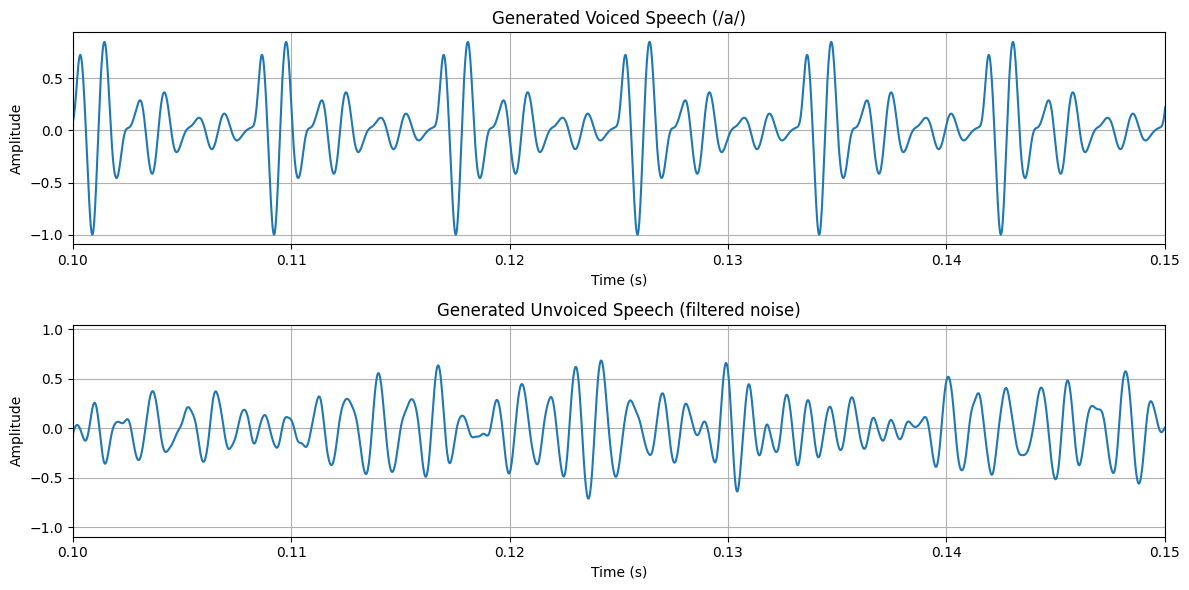

In [4]:
# (b) Plot the generated speech signal and analyze the effect of the filter

# --- Apply the filter to the source signals ---
# Voiced speech
voiced_speech = signal.lfilter(b_coeffs, a_coeffs, pulse_train)
voiced_speech /= np.max(np.abs(voiced_speech)) # Normalize

# Unvoiced speech
unvoiced_speech = signal.lfilter(b_coeffs, a_coeffs, white_noise)
unvoiced_speech /= np.max(np.abs(unvoiced_speech)) # Normalize

# --- Plot the generated speech signals ---
plt.figure(figsize=(12, 6))

# Plot Voiced Speech
plt.subplot(2, 1, 1)
plt.plot(t, voiced_speech)
plt.title('Generated Voiced Speech (/a/)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.1, 0.15) # Zoom in
plt.grid(True)

# Plot Unvoiced Speech
plt.subplot(2, 1, 2)
plt.plot(t, unvoiced_speech)
plt.title('Generated Unvoiced Speech (filtered noise)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.1, 0.15) # Zoom in
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Listen to the generated sounds (optional) ---
# print("Playing synthetic voiced speech...")
# sd.play(voiced_speech, sample_rate)
# sd.wait()

# print("\nPlaying synthetic unvoiced speech...")
# sd.play(unvoiced_speech, sample_rate)
# sd.wait()

## 4. Sampling and Reconstruction of Synthetic Speech

Now, we will take the synthetic `voiced_speech` signal we just created and analyze how it is affected by sampling and reconstruction. This is the same process we followed in Task 1, but now applied to our model-generated signal.

--- Sampling Synthetic Signal ---


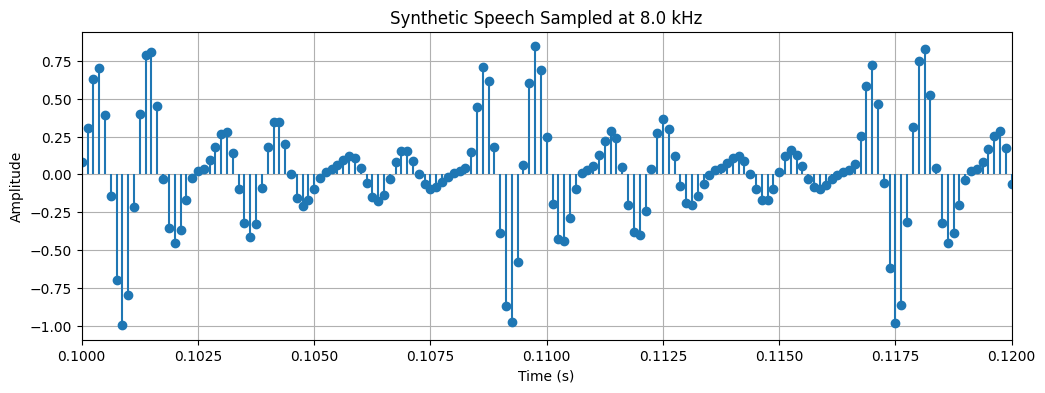

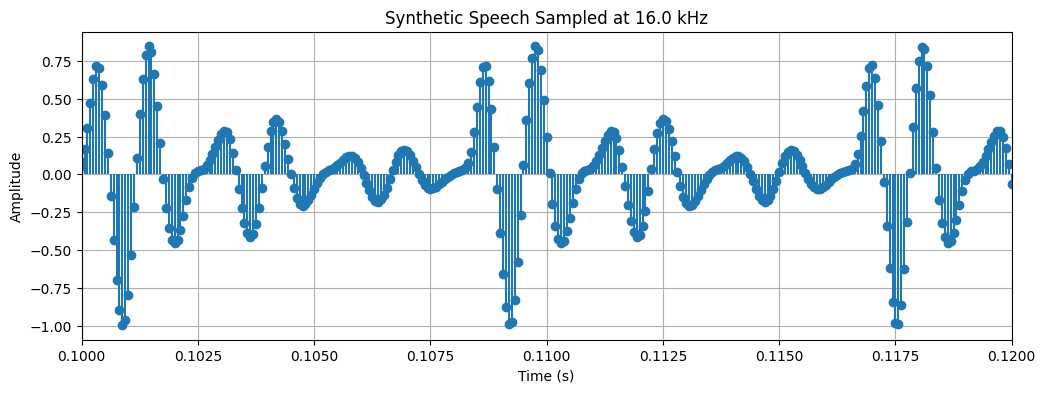

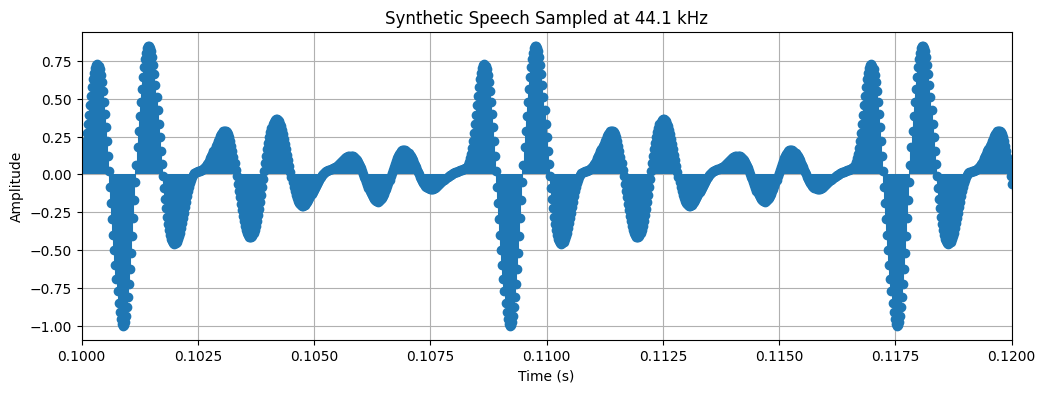

In [5]:
# (c) Sample the speech signal generated above at different sampling rates

target_rates = [8000, 16000, 44100]  # Hz
original_synthetic_signal = voiced_speech
original_rate = sample_rate # This is 44100 Hz

sampled_synthetic_signals = {}

print("--- Sampling Synthetic Signal ---")
for rate in target_rates:
    # Calculate the number of samples in the resampled signal
    num_samples = int(len(original_synthetic_signal) * rate / original_rate)
    
    # Resample the signal
    sampled_signal = signal.resample(original_synthetic_signal, num_samples)
    sampled_synthetic_signals[rate] = sampled_signal
    
    # Create a time axis for the sampled signal
    sampled_time = np.linspace(0., duration, num_samples)
    
    # Plot the sampled signal
    plt.figure(figsize=(12, 4))
    plt.stem(sampled_time, sampled_signal, basefmt=" ")
    plt.title(f'Synthetic Speech Sampled at {rate / 1000} kHz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xlim(0.1, 0.12) # Zoom in to a 20ms segment
    plt.show()

## 5. Reconstruct and Calculate MSE

We'll now reconstruct the signal from the samples using both Zero-Order Hold and Linear Interpolation, and then calculate the Mean Squared Error to quantify the reconstruction quality.

--- Reconstruction and MSE Analysis ---

Sampling Rate: 8.0 kHz
  MSE (Zero-Order Hold): 0.0412632130
  MSE (Linear Interpolation): 0.0097708626


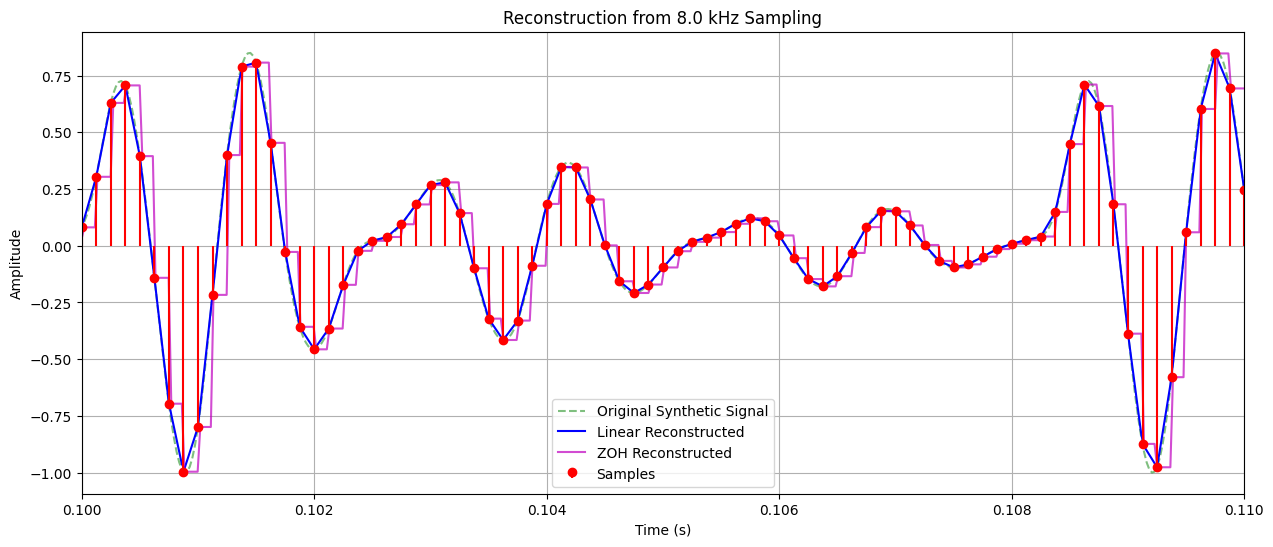


Sampling Rate: 16.0 kHz
  MSE (Zero-Order Hold): 0.0088629615
  MSE (Linear Interpolation): 0.0015359993


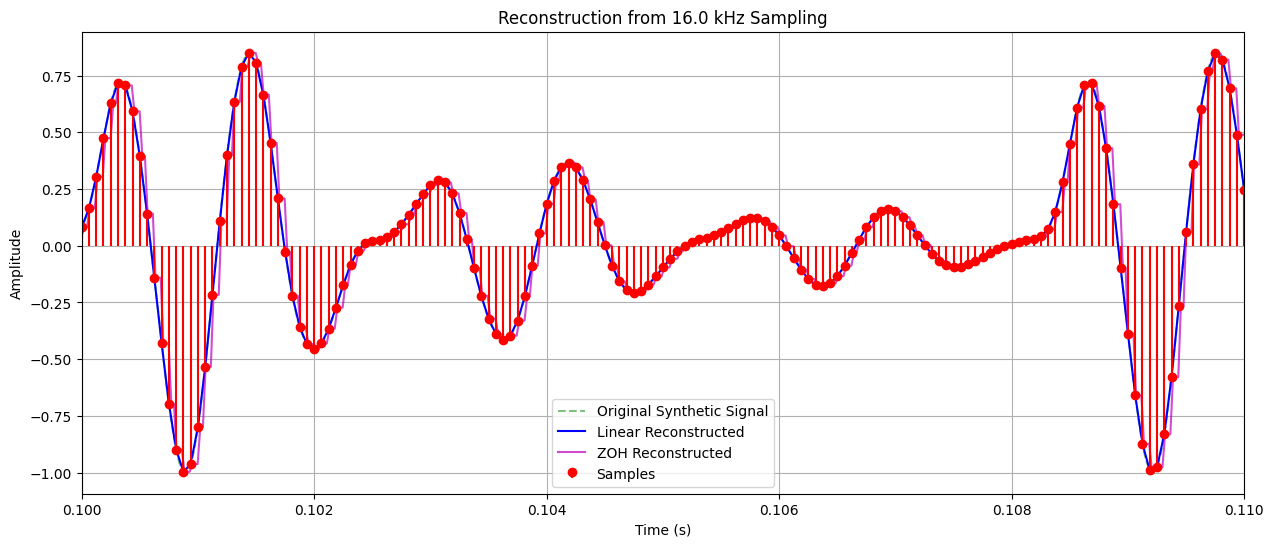


Sampling Rate: 44.1 kHz
  MSE (Zero-Order Hold): 0.0000000000
  MSE (Linear Interpolation): 0.0000000000


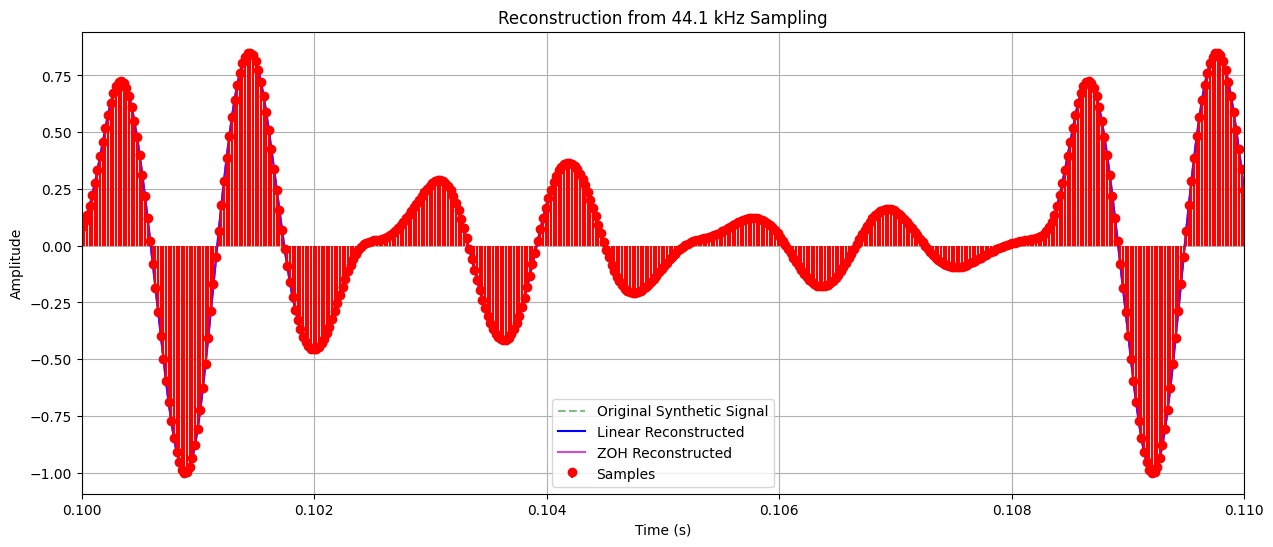

In [7]:
# (d) Reconstruct the signal using a suitable interpolation method
# (e) Compute the Mean Squared Error (MSE)

from scipy.interpolate import interp1d

def mean_squared_error(original, reconstructed):
    """Calculates the Mean Squared Error between two signals."""
    return np.mean((original - reconstructed)**2)

print("--- Reconstruction and MSE Analysis ---")

for rate, sampled_signal in sampled_synthetic_signals.items():
    # --- Time axes ---
    sampled_time = np.linspace(0., duration, len(sampled_signal))
    original_time = np.linspace(0., duration, len(original_synthetic_signal))

    # --- Reconstruction ---
    # Zero-Order Hold
    f_zoh = interp1d(sampled_time, sampled_signal, kind='zero', fill_value="extrapolate")
    reconstructed_zoh = f_zoh(original_time)
    
    # Linear Interpolation
    f_linear = interp1d(sampled_time, sampled_signal, kind='linear', fill_value="extrapolate")
    reconstructed_linear = f_linear(original_time)

    # --- MSE Calculation ---
    mse_zoh = mean_squared_error(original_synthetic_signal, reconstructed_zoh)
    mse_linear = mean_squared_error(original_synthetic_signal, reconstructed_linear)
    
    print(f"\nSampling Rate: {rate/1000} kHz")
    print(f"  MSE (Zero-Order Hold): {mse_zoh:.10f}")
    print(f"  MSE (Linear Interpolation): {mse_linear:.10f}")

    # --- Plotting ---
    plt.figure(figsize=(15, 6))
    plt.plot(original_time, original_synthetic_signal, 'g--', label='Original Synthetic Signal', alpha=0.5)
    plt.plot(original_time, reconstructed_linear, 'b-', label='Linear Reconstructed')
    plt.plot(original_time, reconstructed_zoh, 'm-', label='ZOH Reconstructed', alpha=0.7)
    plt.stem(sampled_time, sampled_signal, 'r', markerfmt='ro', basefmt=' ', label='Samples')
    plt.title(f'Reconstruction from {rate/1000} kHz Sampling')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.xlim(0.1, 0.11) # Zoom in
    plt.grid(True)
    plt.show()

## 6. Inference

Based on the source-filter model implementation, the subsequent sampling, and the reconstruction results, write your final inference here.

**Key points to consider:**

*   **Source-Filter Model:** How did the filter change the source signal (pulse train)? Did the frequency response of the filter match the resulting waveform of the synthetic speech?
*   **Effect of Sampling Rate on Synthetic Speech:** How did the MSE for the synthetic speech change as the sampling rate was lowered? Was the effect similar to what you observed in Task 1 with the real audio file?
*   **Reconstruction Methods:** Which reconstruction method performed better for the synthetic signal, according to the MSE values?
*   **Overall Conclusion:** Summarize the entire process, from creating a synthetic vowel sound to analyzing the digital representation errors introduced by sampling.